<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle, Circle, ConnectionPatch
from IPython.display import Image
import sys
import pandas as pd
import HTM_Code as hc
import colorsys

So we now have a sense of a number of things: 

* We can create SDRS
* We have mechanimsm to evaluate more than 1 SDRs
* We have a way to deal with fault tolerance and add noise to SDRs
* We have encoder which takes a value in and encodes it in a numerical way that semantics
* We have a multi numerical encoder that allows us to join a numbrer of numerical encoders
* We have some nice visualisation functions

I have put them into into code file which for now we will just keep as one big file. 

We now come to the next big component of a HTM system: The Spatial Pooler (SP). From the literature: 

<i>The SP models how neurons learn feedforward connections and form efficient represetntnations of the input. It convers arbitrary binary input patterns into sparse distributed representations (SDRs) using a comintation of competitive Hebbian leanig rules and homeostatic excitability control</i>

There is an awful lot in the that sentence, and the best way forward is tackle things with an example, and develop our understanding. Our resource, will be HTM school along with a couple of key papers: 

* HTM Spatial Pooler - Neocortical Algorthm for Online Sparse Distributed Encoding
* BAMI - Chapter on spatial pooler. 

In [2]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/R5UoFNtv5AU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

To get an understanding of the Spatial Pooler, we will also use some data, which comes from a classic example used in HTM, tracking the power consuptiom in a gymnasium over time. Let's import the data and have a look at it: 

In [3]:
df = pd.read_csv("./data/gymdata.csv", header=1)
df = df.rename(columns={"datetime": "date_time", "float": "power_consumption"})
df = df.iloc[1:]
df.head()

,date_time,power_consumption
1,7/2/10 0:00,21.2
2,7/2/10 1:00,16.4
3,7/2/10 2:00,4.7
4,7/2/10 3:00,4.7
5,7/2/10 4:00,4.6


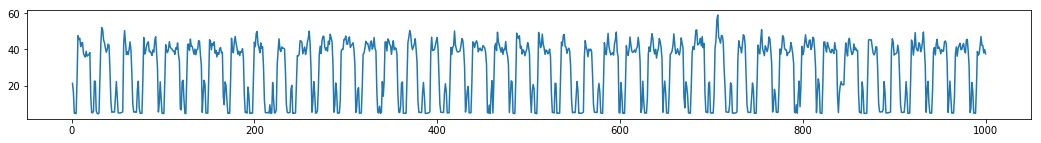

In [4]:
df.power_consumption[:1000].plot(figsize = (18,2))

This gives us a bit of a sense of how things look from record to record. I will do bit of work on the data set, just to clean up the columns, to seperate date and time, and create an indicator of whether its weekend or not, so the data can easily be placed in an encodeer

In [5]:
df.date_time = pd.to_datetime(df.date_time, format="%m/%d/%y %H:%M")
df['date'] = [d.date() for d in df.date_time]
df['time_of_day'] = [d.time() for d in df.date_time]
df['weekday'] = [d.weekday() for d in df.date]
df['is_weekend'] = df.loc[df.weekday < 4, 'weekday'] = 0
df['is_weekend'] = df.loc[df.weekday >= 4, 'weekday'] = 1
df = df.drop('date_time', axis=1)
df = df.drop('weekday', axis=1)

df.head()

,power_consumption,date,time_of_day,is_weekend
1,21.2,2010-07-02,00:00:00,1
2,16.4,2010-07-02,01:00:00,1
3,4.7,2010-07-02,02:00:00,1
4,4.7,2010-07-02,03:00:00,1
5,4.6,2010-07-02,04:00:00,1


We have also added some more terms to our glossary, so let's bring that in too and sort it by spatial pooler tag:

In [6]:
glossary = pd.read_csv("./data/glossary.csv", header=0)
glossary.loc[glossary['Tags'].str.contains("spatial pooler")].style.set_properties(**{'text-align': 'left'})

,Tags,Term,Description
0,spatial pooler,Column,"An HTM region is organized in columns of cells. The SP operates at the column-level, where a column of a cells function as a single computational unit."
1,spatial pooler,Inhibition,The mechanism for maintaining sparse activations of neurons. In the SP this manifests as columns inhibiting nearby columns from becoming active.
2,spatial pooler,Inhibition radius,"The size of a column's local neighborhood, within which columns may inhibit each other from becoming active."
3,spatial pooler,Active duty cycle,A moving average denoting the frequency of column activation.
4,spatial pooler,Overlap duty cycle,A moving average denoting the frequency of the column's overlap value being at least equal to the proximal segment activation threshold.
5,spatial pooler,Receptive field,The input space that a column can potentially connect to
6,spatial pooler,Permance value,"indicates the amount of growth between a mini-column in the Spatial Pooling algorithm and one of the cells in its receptive field. Acceptable values are [0,1]."
7,spatial pooler,Permance threshold,"If a synapse's permanence is above this value, it is considered fully connected."
8,spatial pooler; neuroscience,Synapse,"A junction between cells. In the Spatial Pooling algorithm, synapses on a column's dendritic segment connect to bits in the input space. A synapse can be in the following states: Connected: permanence is above the threshold, Potential: permanence is below the threshold, Unconnected: does not have the ability to connect."


- An SDR arrives at the neocortex through the thalumus
- Neocortex is structuced into regions and in each of these regions is columns of cells (montcastle)
- each column has associated dendritic segment which is the connection to the input space
- each dendrectic segment has potential synapses representing a random subset of input bits


spatial pooling.....

biology of neocorext

heiracty of regions....gets input from sensory etc. 

input space is figure optics, whether neuron is on or off

cortex needs to normalise input in order to learn....

size of input space variable - look at it in different ways

SP - gets input vector.....translates into output vector with a sparse number of active bits

Output vector of SP represents minicolumns...which are col of pyramidal neorons in the neorcrotex....important 

2 goals of spatial pooling...
- maintain fixed sparsity - as it sees input SP will maintain sparsity
- maintain overlap properties  

...need to recognise overlaps in input etc....

spatial pooler is learning algorithm.... today we talk about input space


SP input space - is multi encoder from gym example
- each data points represented in input space

Aim one - iterate through all dat and encode...

This data set has certain signatures......could be random input or not....semantic meaning remains...

Step 1 - feed data into multiencoder   

Step 2.....inititalise
LEFT - SOME INPUT SPACE
RIGHT - SP COLUMNS
so each SP columsn is connected to subset of input spacte

Every column has potential pool that it might be connected to - randomly potentially connected - here to 85%, we can reset..... SP has initial settings
each of the 85% of potential connections has permanence connected...heat map shows connections - which has no connection in red, then heat map connections

white cells - no connection to
all others have a permance value that may be below threshold

each col has relationship to every cel in input space
- some will never connect
- others will have different levels of connectivity
- blue circle means there is a connection from columm to cell in input space, and 
- blue circles are an outomce of of if permance threshold is met, they can have a connection - so all squares have either no, connectino, connection below threshold, or connection above threshold, and those above are blue dots apppear

- can change to .4 - map to only 40%, and then blue dots appear only above connection threshold of that 40% - 
- POTENTIAL POOL - all possible connections set to 85%, then 40%
- CONNECTINO THRESHOLD - set heatmap, and blue dots - randominly initialise heatmap settings I think
- in setting up  permance valus randomly, this happens around the threshold.....so number of connections still kind of works - set up  as normal distribution around connection threshold

Now.....we can look at input.. we get random SDR coming in....

Eeach column mapped to input space

We can consider if col mapped to input space, some overlapping with data, some don't 

Idea is that cols learn, through reinforcement (see input on connection) or don't see anything

Also - idea of input / cell overlap

use overlap to "activate cols" - 


So this tells us we need 4 numerical encoders: 1 for consumption, one for time of day, 1 for weekend. We need to think about paramaters




<div style="padding-left: 150px; padding-right: 150px; ">

<i>First, the values are chosen to be in a small range around connectedPerm, the minimum permanence value at which a synapse is considered “connected”. This enables potential synapses to become connected (or disconnected) after a small number of training iterations. Second, each column has a natural center over the input region, and the permanence values have a bias towards this center, so that they have higher values near the center.</i>
    <br/>
    <br/>
    -- Spatial Pooling, Biological & Machine Intelligence
</div>

We are going to create a vew different versions, that beomce more complicated. We will need to optimise, but we also want to proceed slowly as this quite complicated. First we are just going to create columns 
We need to do two things
- connect the columns to the input space 
- assign weights to teh the columns



In [7]:
# first we create connection from each column
# then we set initial potential 
class SpatialPoolerV1:
    def __init__(self):
        self.input_space_size = 400
        self.potential_pool = .45
        self.connection_threshold = 0.1
        self.columns = {}
        self.connected_columns = None
        self.non_connected_columns = None
        self.connected_columns_permanence_values = None
        
        
    def connect_columns_to_input_space(self):
        potential_pool_size = int(self.potential_pool * self.input_space_size)
        self.connected_columns = hc.create_randomised_sdr(self.input_space_size, potential_pool_size)
        self.non_connected_columns = [x for x in range(0, 64) if x not in self.connected_columns]
        self.connected_columns_permanence_values = np.random.normal(self.connection_threshold, 0.01, potential_pool_size)

            

In [8]:
s1 = SpatialPoolerV1()
s1.connect_columns_to_input_space()

In [9]:
bit_space_size_choice = 400
number_of_bits_used_to_encode_value_choice = 8

e2 = hc.Encoder(bit_space_size = bit_space_size_choice,
                number_of_bits_used_to_encode_value = number_of_bits_used_to_encode_value_choice,
                min_val = 0,
                max_val =300,
            is_randomly_distributed = True,
            clip_values_outside_range = True)
#e2.get_summary()

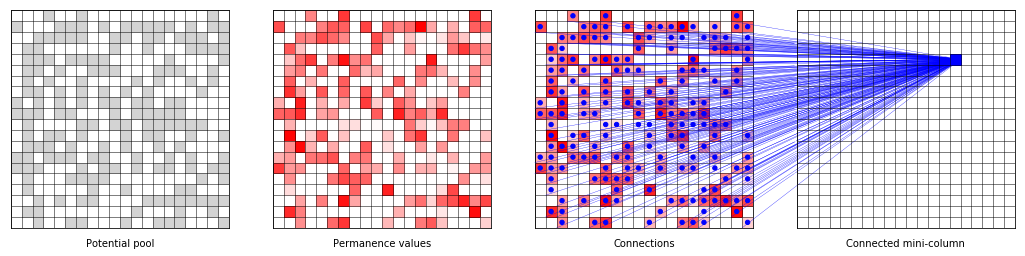

In [16]:
def compute_color(c):
    ival = np.interp(c,[min(s1.connected_columns_permanence_values),max(s1.connected_columns_permanence_values)],[0,1])
    rgb = colorsys.hsv_to_rgb(0, ival,  1)
    return(rgb)

def move_circle(c):
    coords = np.array(c)
    coords = coords + .5
    return(tuple(coords))


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = hc.create_axis_for_sdr(ax1, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Potential pool")
ax2 = hc.create_axis_for_sdr(ax2, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Permanence values")
ax3 = hc.create_axis_for_sdr(ax3, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Connections")
ax4 = hc.create_axis_for_sdr(ax4, np.sqrt(bit_space_size_choice) + 1, np.sqrt(bit_space_size_choice) + 1, number_of_bits_used_to_encode_value_choice, "Connected mini-column")

coords1 = hc.convert_sdr_to_tuple_for_visualisation(s1.connected_columns, bit_space_size_choice)
p1 = [ax1.add_patch(Rectangle(coords1[i], 1, 1, color = "lightgray")) for i in range(len(coords1))]
p1 = [ax2.add_patch(Rectangle(coords1[i], 1, 1, color = compute_color(s1.connected_columns_permanence_values[i]))) for i in range(len(coords1))]
p2 = [ax3.add_patch(Rectangle(coords1[i], 1, 1, color = compute_color(s1.connected_columns_permanence_values[i]))) for i in range(len(coords1))]
p3 = [ax3.add_patch(Circle(move_circle(coords1[i]), .2, color = "blue")) for i in range(len(coords1))]
p3 = ax4.add_patch(Rectangle((14,15), 1, 1, color = "blue"))
p3 = [ax4.add_artist(ConnectionPatch(xyA=(15,15.5), xyB=coords1[i], coordsA="data", coordsB="data",
                      axesA=ax4, axesB=ax3, color="blue", linewidth = 0.3)) for i in range(len(coords1))]

plt.savefig("./Images/spatial_pooler_columns.svg", dpi = 300)

<div style="background:#99ddff; color:black; padding: 10px">
<b>Add to these notes:</b>
    <br/>
<div>I love matplotlib, but sometimes rendering really high quality images directly is difficulty NOte that can also write image svg files. Just an aside to say this quite I created one with the last line of code
    </div>
    <img src = "Images/spatial_pooler_columns.svg"></img>
</div>

Let's build another encoder now, and we can explain as we use it: 